<a href="https://colab.research.google.com/github/Jaseelkt007/ML-Sandbox/blob/master/Effect_of_Activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lets answer following questions

1. why not just pure linear neuron ?
2. Add a nonlinearity (no gating)
3. Why can't pass negative values
4. Introduce the idea of suppressing signals
5. Hard gating
6. Soft gating ( sigmoid / GELU / swilu)

##1. Pure Linear neuron (baseline)

Lets consider a simple neuron :  $y = w^\top x$

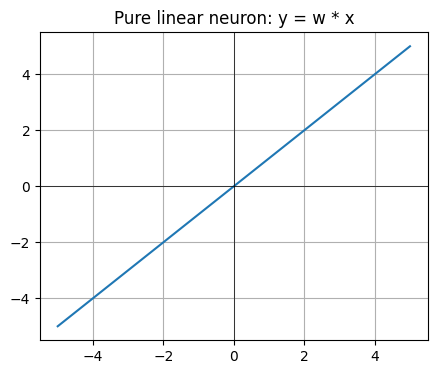

In [5]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

# 1D input for visualization
x = torch.linspace(-5, 5, 1000)

# single weight
w = torch.tensor(1.0)

y = w * x

plt.figure(figsize=(5,4))
plt.plot(x, y)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Pure linear neuron: y = w * x")
plt.grid(True)
plt.show()



## Observation
* Perfect straight line
* Negative passes fully
* Positive passes fully
* No selectivity

## 2. Stack linear neurons ( Linear)

Lets stack two layers $y = w_2(w_1 x) $


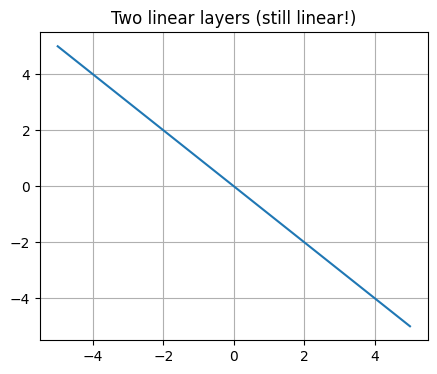

In [6]:
w1 = torch.tensor(2.0)
w2 = torch.tensor(-0.5)

y2 = w2 * (w1 * x)

plt.figure(figsize=(5,4))
plt.plot(x, y2)
plt.title("Two linear layers (still linear!)")
plt.grid(True)
plt.show()


### Observation
* Still a straight line
* Depth didn’t help
### Conclution
Depth without non linearity is useless

##3. Add a nonlinear function ( no gating )
tanh : $y = tanh(w x)$



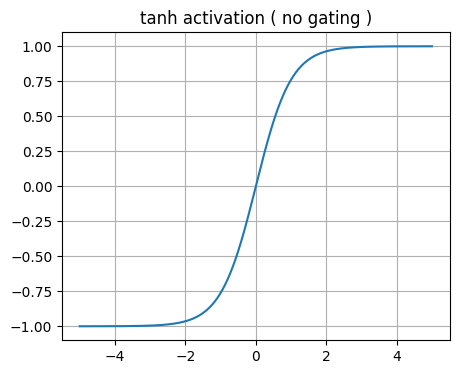

In [7]:
y_tanh = torch.tanh(w*x)

plt.figure(figsize=(5,4))
plt.plot(x, y_tanh)
plt.title("tanh activation ( no gating )")
plt.grid(True)
plt.show()

### Observation
* Negative values passes through
* Positive values pass
* Saturates +-1
Even though its nonlinear neuron always responds, it never says "this input is irrelevent"
### Conclusion
Non linearity $\neq$ Selectivity

## 4. Compose features ( why always passing is bad )
Lets imagine two neurons feeding in to one

Setup
* Neuron A outputs something irrelevent
* Neuron B outputs something relevent

But both always pass

and $x_1$ = x (usefull) , $x_2$ = random junk (irrelevent)

let $y = 3x$ : true y

Linear Model without gating : y predicted :  $\hat{y} = w_1 x_1 + w_2 x_2$



In [16]:
# Two features
torch.manual_seed(0)

N = 2000
x = torch.randn(N, 1)

x1 = x                       # useful feature
x2 = torch.randn(N, 1)       # irrelevant feature

X = torch.cat([x1, x2], dim=1)
y_true = 3 * x


In [17]:
W = torch.randn(2,1, requires_grad=True)
optimizer = torch.optim.SGD([W], lr=0.1)

for _ in range(200):
    y_pred = X @ W
    loss = ((y_pred - y_true)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("learned weights: ", W.detach().squeeze())

learned weights:  tensor([3.0000e+00, 4.8082e-08])


### Observation
* The model tries to push $w_2 \to 0$
* But noise always contributes
* with deeper network this gets worse

### Stack layers ( add depth) : the real problem

In [34]:
W1 = torch.randn(2,8, requires_grad=True)
W2 = torch.randn(8, 1, requires_grad=True)

params = [W1, W2]
optimizer = torch.optim.Adam(params, lr=0.05)

for _ in range(200):
    # h = torch.relu(X @ W1)
    h = X @ W1
    y_pred = h @ W2
    loss = ((y_pred - y_true)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Final loss:", loss.item())
print("="*100)
print("W1 (input → hidden) weights:", W1.detach())
print("="*100)
print("W2 (hidden → output) weights:", W2.detach())
print("="*100)


Final loss: 9.605464201811742e-10
W1 (input → hidden) weights: tensor([[ 0.4865,  1.2135, -0.1331, -1.1891,  1.1246,  0.8477,  1.8535,  1.3272],
        [-0.4453, -0.9755,  1.4576, -0.9308,  0.5355, -0.1985, -0.5824, -0.4478]])
W2 (hidden → output) weights: tensor([[ 0.5570],
        [ 0.0365],
        [-0.8847],
        [-1.4447],
        [ 0.5650],
        [-0.0799],
        [ 0.1175],
        [ 0.0480]])


### Observation
* Noise feature enters layer 1
* Mixed into all hidden units
* Propogated deeper
* No way to turn it off

Even adding a non linearity using tanh , doesn't stop noise from entering, it only reshapes, it doesn't control participation

## 5. Introduce the idea of suppression
* $y = \text{signal} \times \text{gate}$

signal can be positive or negative , gate is a relevence score

$\text{gate} \approx \text{relevance}$

$\text{gate} \approx 0 \Rightarrow \text{suppress}$

$\text{gate} \approx 1 \Rightarrow \text{pass}$

### Additive nonlinearity
$$h(x) = \phi(w^\top x)$$
* Always participate
* Always mixes
* No way to turn off contribution
### Multiplicative gating
$$h(x) = (w_a^\top x) \cdot g(w_b^\top x)$$
* One part decids what
* One part decides whether
* Noise can be suppresed




## 6. Hard gating (step function)
$\text{gate}(x) = \begin{cases}
1 & \text use \\
0 & \text ignore
\end{cases}$

This solves noise propogation perfectly but
Gradient = 0 almost everywhere

but Deeper models : Noise accumulates


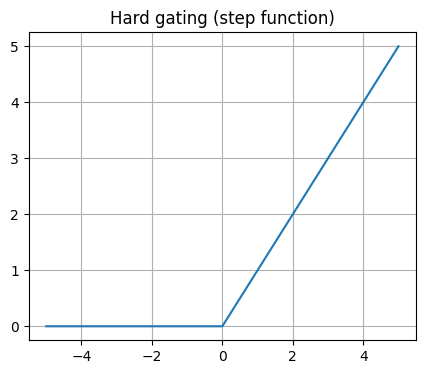

In [9]:
gate = (x > 0).float()
y_gate = x * gate

plt.figure(figsize=(5,4))
plt.plot(x, y_gate)
plt.title("Hard gating (step function)")
plt.grid(True)
plt.show()

### Observation
* Negative suppressed
* Positive passed
* Perfect selectivity

Now lets try to backprogate


In [15]:
x = torch.randn(1000, requires_grad=True)
y = x * (x > 0).float()

y.sum().backward()
print(x.grad[:10])

tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])


### Observation
Gradient = 0 almost everywhere ( x< 0)
### conclusion
Hard gating kills learning. Perfect control , zero gradients.

## 7. We want Soft gating
* Suppression ability (like hard gating)
* Gradient ( like tanh)

### Sigmoid gating.
$$h = z \cdot \sigma(z)$$

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
* z is the content , and $\sigma(z)$ is the relevence gate
* Negative contents are not "forbidden", they are just downgraded if the gate is small

Derivate

$$\frac{d}{dz}[z \sigma(z)] = \sigma(z) + z \sigma(z)(1 - \sigma(z))$$
* its smooth

Now lets answer the following quetions ?
1. Noise propagation: does the model reduce dependence on noise feature $x_2$ ?
2. Dead gradients: does training stall due to many zero-grad units?
3. Behavior: how sparse is the hidden layer? how strong are gradients?


In [36]:
torch.manual_seed(0)

def make_dataset(n: int = 4000):
    x = torch.randn(n, 1)
    x1 = x                      # useful
    x2 = torch.randn(n, 1)      # noise
    X = torch.cat([x1, x2], dim=1)
    y = 3.0 * x1
    return X, y

def mse(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    return ((y_pred - y_true) ** 2).mean()

def corr(a: torch.Tensor, b: torch.Tensor) -> float:
    a = a.squeeze()
    b = b.squeeze()
    a = (a - a.mean()) / (a.std() + 1e-8)
    b = (b - b.mean()) / (b.std() + 1e-8)
    return float((a * b).mean().item())


In [37]:
from dataclasses import dataclass

@dataclass
class RunStats:
    losses: list
    zero_frac: list
    grad_w1: list
    grad_w2: list
    corr_pred_x2: list

def forward_hidden(X: torch.Tensor, W1: torch.Tensor, mode: str) -> torch.Tensor:
    z = X @ W1
    if mode == "linear":
        return z
    if mode == "relu":
        return torch.relu(z)
    if mode == "sigmoid_gate":  # SiLU / Swish-1
        return z * torch.sigmoid(z)
    raise ValueError(f"Unknown mode: {mode}")

def train_variant(mode: str, steps: int = 400, lr: float = 0.05, hidden: int = 8) -> RunStats:
    X, y_true = make_dataset()
    W1 = torch.randn(2, hidden, requires_grad=True)
    W2 = torch.randn(hidden, 1, requires_grad=True)
    opt = torch.optim.Adam([W1, W2], lr=lr)

    stats = RunStats(losses=[], zero_frac=[], grad_w1=[], grad_w2=[], corr_pred_x2=[])

    for _ in range(steps):
        h = forward_hidden(X, W1, mode)
        y_pred = h @ W2
        loss = mse(y_pred, y_true)

        opt.zero_grad()
        loss.backward()
        opt.step()

        with torch.no_grad():
            stats.losses.append(float(loss.item()))
            stats.zero_frac.append(float((h == 0).float().mean().item()))
            stats.grad_w1.append(float(W1.grad.norm().item()))
            stats.grad_w2.append(float(W2.grad.norm().item()))
            # How much predictions correlate with noise feature x2?
            x2 = X[:, 1:2]
            stats.corr_pred_x2.append(corr(y_pred, x2))

    return stats

linear_stats = train_variant("linear")
relu_stats = train_variant("relu")
sig_stats = train_variant("sigmoid_gate")


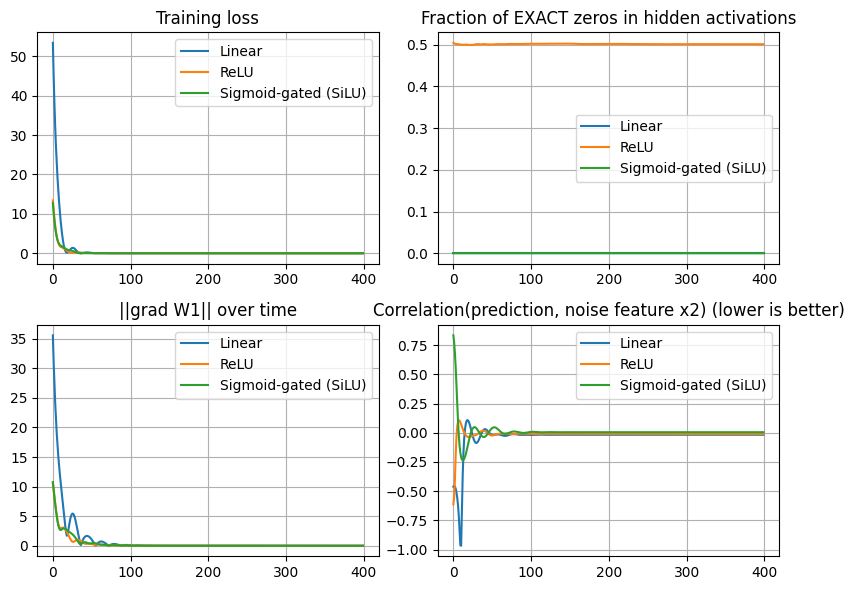

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# --- 1. Training loss ---
axes[0, 0].plot(linear_stats.losses, label="Linear")
axes[0, 0].plot(relu_stats.losses, label="ReLU")
axes[0, 0].plot(sig_stats.losses, label="Sigmoid-gated (SiLU)")
axes[0, 0].set_title("Training loss")
axes[0, 0].grid(True)
axes[0, 0].legend()

# --- 2. Fraction of EXACT zeros ---
axes[0, 1].plot(linear_stats.zero_frac, label="Linear")
axes[0, 1].plot(relu_stats.zero_frac, label="ReLU")
axes[0, 1].plot(sig_stats.zero_frac, label="Sigmoid-gated (SiLU)")
axes[0, 1].set_title("Fraction of EXACT zeros in hidden activations")
axes[0, 1].grid(True)
axes[0, 1].legend()

# --- 3. ||grad W1|| over time ---
axes[1, 0].plot(linear_stats.grad_w1, label="Linear")
axes[1, 0].plot(relu_stats.grad_w1, label="ReLU")
axes[1, 0].plot(sig_stats.grad_w1, label="Sigmoid-gated (SiLU)")
axes[1, 0].set_title("||grad W1|| over time")
axes[1, 0].grid(True)
axes[1, 0].legend()

# --- 4. Correlation(prediction, noise feature x2) ---
axes[1, 1].plot(linear_stats.corr_pred_x2, label="Linear")
axes[1, 1].plot(relu_stats.corr_pred_x2, label="ReLU")
axes[1, 1].plot(sig_stats.corr_pred_x2, label="Sigmoid-gated (SiLU)")
axes[1, 1].set_title("Correlation(prediction, noise feature x2) (lower is better)")
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


### Observation
* ReLU shows higher zero fraction (hard sparsity).
* Sigmoid-gated shows almost no exact zeros (soft sparsity).
* ReLU may have moments where gradients get smaller / unstable because many units are off.
* Sigmoid-gated keeps gradients more “alive”.
* Correlation with noise feature $x_2$ should generally reduce with nonlinear/gated methods vs linear.

### Lets visualize gate distribution $\sigma(z)$

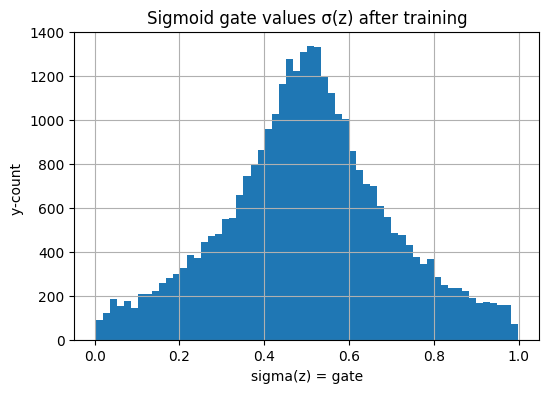

In [62]:
def inspect_gate_distribution(hidden: int = 8):
    X, _ = make_dataset()
    W1 = torch.randn(2, hidden, requires_grad=True)
    W2 = torch.randn(hidden, 1, requires_grad=True)
    opt = torch.optim.Adam([W1, W2], lr=0.05)

    # quick train
    for _ in range(400):
        z = X @ W1
        h = z * torch.sigmoid(z)
        y_pred = h @ W2
        loss = mse(y_pred, 3.0 * X[:, 0:1])
        opt.zero_grad()
        loss.backward()
        opt.step()

    with torch.no_grad():
      z = X @ W1
      g = torch.sigmoid(z)   # gate values used

    plt.figure(figsize=(6,4))
    plt.hist(g.flatten().cpu().numpy(), bins=60)
    plt.xlabel("sigma(z) = gate")
    plt.ylabel("y-count ")
    plt.title("Sigmoid gate values σ(z) after training")
    plt.grid(True)
    plt.show()

inspect_gate_distribution()


### Interpretation : many gates are half open
* Values near 0 : mostly suppresses
* Values near 1 : mostly pass
* Values in middle : ( z = 0 ie, i am uncertain whether this feature is usefull )


Sigmoid gating fixes "the dead gradient" issues of hard gating but introduces new problems
* Saturation : vanishing gradient
* when z >> 0 : $\sigma(z) \approx 1$ and $\sigma'(z) \approx 0$
* when z << 0 : $\sigma(z) \approx 0$ and $\sigma'(z) \approx 0$

So even though gradient is not exactly zero like ReLU, it can become very small for large |z|.


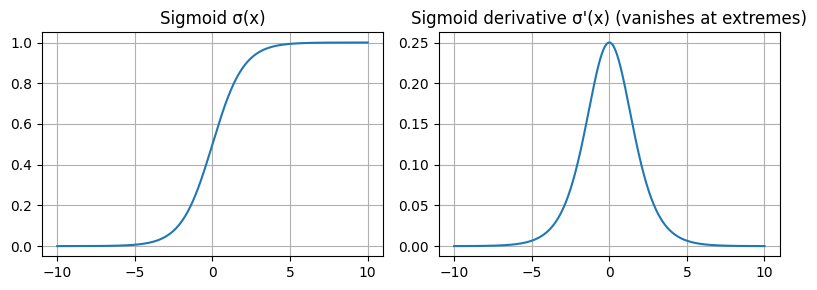

In [50]:
x = torch.linspace(-10, 10, 2000, requires_grad=True)
s = torch.sigmoid(x)
s.sum().backward()
ds = x.grad.detach()

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# --- Sigmoid ---
axes[0].plot(x.detach(), s.detach())
axes[0].set_title("Sigmoid σ(x)")
axes[0].grid(True)

# --- Sigmoid derivative ---
axes[1].plot(x.detach(), ds)
axes[1].set_title("Sigmoid derivative σ'(x) (vanishes at extremes)")
axes[1].grid(True)

plt.tight_layout()
plt.show()



* Gate $\sigma(z) \in (0, 1)$ can shrink or pass, but cannot invert.
* That's fine because the content can be negative: $$h = z \cdot \sigma(z)$$
still supports negative outputs via z.
* But the gate itself can't represent "anti-gate" behavours

### Two conflicting roles if you use z for both content & gate
in $h = z \cdot \sigma(z)$ , the same z controls:
* the value
* the gate strength

Sometimes we want:
* gate depends on one project
* content depends on another projection


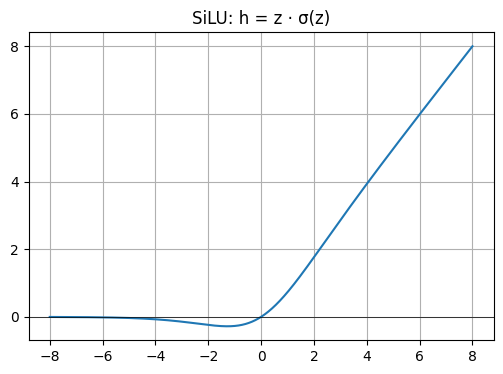

In [63]:
z = torch.linspace(-8, 8, 2000)
h = z * torch.sigmoid(z)

plt.figure(figsize=(6,4))
plt.plot(z, h)
plt.axhline(0, color="black", linewidth=0.5)
plt.title("SiLU: h = z · σ(z)")
plt.grid(True)
plt.show()


### Observation
* For large negative z --> output almost zero ( content lost )
* For large positive z --> almost linear

So
* Strong negative signals are harder to represent
* Not because negative values are bad
* But because gate and content are entangled

Suppose the model wants a strong negative value ( important evidence against something) but also wants to pass it through.
Large negative z ---> $\sigma(z) \approx 0$ so h ==> 0.
* The signal is destroyed, not because it's irrelevent, but because gate and content are together.


##Content and gating should not be entangled

1. $h =(x W_b)\,\sigma(x W_b)$ ----- (GLU)
2. $h = (x W_a) \odot \mathrm{SiLU}(x W_b)$ ------- (SwiGLU)
* SWIGLU often works better because the gate magnitude aware not just 0..1 mask and tends to optimize well at Scale
  * More expressive gating
  * Often better optimization
  * Better "smoothness"

$x W_a$ = the content

$x W_b$ = gate per-activation

SiLU = gate
* No gate depends on content
* Strong negative content is allowed
* Gate decides relevence independently

In [64]:
N = 4000
x = torch.randn(N, 1)

x1 = x                      # useful
x2 = torch.randn(N, 1)      # noise

X = torch.cat([x1, x2], dim=1)
y_true = 3 * x1


Wa = torch.randn(2, 8, requires_grad=True)  # content
Wb = torch.randn(2, 8, requires_grad=True)  # gate
W2 = torch.randn(8, 1, requires_grad=True)

opt = torch.optim.Adam([Wa, Wb, W2], lr=0.05)

for _ in range(400):
    content = X @ Wa
    gate = torch.sigmoid(X @ Wb) * (X @ Wb)   # SiLU gate
    h = content * gate
    y_pred = h @ W2
    loss = ((y_pred - y_true)**2).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

loss.item()


0.07862915098667145

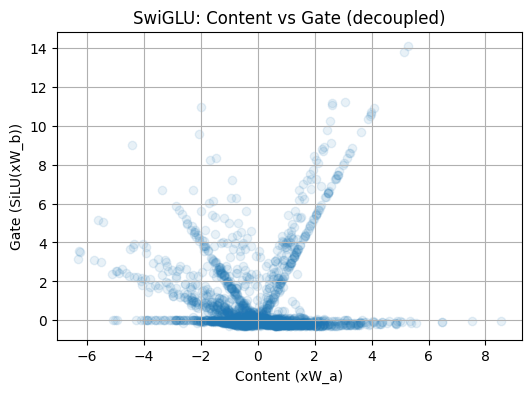

In [73]:
with torch.no_grad():
    c = content.detach().flatten()
    g = gate.detach().flatten()

plt.figure(figsize=(6,4))
plt.scatter(c[:2000], g[:2000], alpha=0.1)
plt.xlabel("Content (xW_a)")
plt.ylabel("Gate (SiLU(xW_b))")
plt.title("SwiGLU: Content vs Gate (decoupled)")
plt.grid(True)
plt.show()



 $$\text{gate} = g \cdot \sigma(g)$$
## Plot explains
1. Fast routing

* Model quickly decides which features matter

2. Sparse gradients

* Many gate gradients become small early

3. Strong inductive bias

* Favors decisive representations


## Key properties
* For moderately negative g, SiLU collapses the gate to near zero, causing effective deactivation
* For sufficiently positive g, SiLU behaves almost linearly and preserves magnitude

SwiGLU learns many gate pre-activations to be negative because negative g is a cheap way to shut off a feature.
* gates shuts almost completely
* Only sufficiently positive g values escape saturation and produce meaningful gate strength

Even though content and gate are technically decoupled
* the gate nonlinearity are itself is asymmetric
* Many neuron-sample pairs are shut off, not necessarily entire neurons permanently.
* This explains faster specialization, conditional sparsity, and aggressive feature selection, at the cost of reduced uncertainty preservation.


### Observation
* No strict correlation
* Gate is independent of content sign
* Negative value are freely passed when gate is open

### Motivation of SiLU
* Fix ReLU's hard cutoff
* keeps gradient alive
* Smooth gating
* Cheap to compute

SiLU implicity assume "Activation strength alone is enough to decide relevence"

1.  But SiLU is **deterministic**
* that is given same z, SiLU always produces the same output.
* There is no notion of uncertainity
* But many problem (speech, language , perception) are inherently ambiguous
2. SiLU gate is magnitude-based, not confidence based
3. SiLU treats noise and signal identicaly
* SiLU assumes input is exact
* activation is reliable , but the real signal are noisy

## GELU starts from a very different assumption
"Activation are noisy measurements of usefulness"

Formally : $z = \text{true signal} + \epsilon,\ \epsilon \sim \mathcal{N}(0, 1)$

### Key idea
Instead of asking : how large is z ? GELU asks What is the probability that z is usefull , that probability is
$$P(\text{activate}) = \mathbb{P}(z_{\text{true}} + \epsilon > 0)$$
$$= \mathbb{P}(\epsilon > -z_{\text{true}})$$
$\text{Since } \epsilon \sim \mathcal{N}(0,1):$
$$ = 1 - \Phi(-z_{\text{true}})
= \Phi(z_{\text{true}})$$
where
$$\Phi(z) = \int_{-\infty}^{z} \frac{1}{\sqrt{2\pi}} e^{-t^{2}/2}\, dt$$


$$\mathbb{P}(z + \epsilon > 0) = \Phi(z)$$

* The intuition is that if z > 0 implies positive evidence for the feature and if z < 0 negative evidence against the feature
where $\Phi$ is the Gaussian CDF.

* $\mathrm{GELU}(z) = z \cdot \Phi(z)$
* z = content
* $\Phi(z) =$ probability the activation should pass

### Noisy strong activation
* SiLU sees magnitude and passes aggressively
* GELU accounts for noise and still suppresses if uncertainty remains

* Strong negative values makes Probability nearly zero, Thats why we move to **GEGLU** like SWIGLU  that preserves strong negative signal when needed

*  $$\mathrm{GEGLU}(x) = (x W_a) \odot \mathrm{GELU}(x W_b)$$
* C = content
* g = gate preactivation
* Gate = GELU (g)


In [76]:
N = 4000
x = torch.randn(N, 1)
x1 = x                      # useful
x2 = torch.randn(N, 1)      # noise
X = torch.cat([x1, x2], dim=1)
y_true = 3 * x1

def gelu(z):
    return 0.5 * z * (1 + torch.tanh(
        math.sqrt(2 / math.pi) * (z + 0.044715 * z**3)
    ))

W = torch.randn(2, 16, requires_grad=True)
Wo = torch.randn(16, 1, requires_grad=True)

opt = torch.optim.Adam([W, Wo], lr=0.05)

for _ in range(400):
    z = X @ W
    h = gelu(z)
    y_pred = h @ Wo
    loss = ((y_pred - y_true)**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

loss_gelu = loss.item()
loss_gelu

0.0002418077492620796

In [88]:
Wa = torch.randn(2, 16, requires_grad=True)  # content
Wb = torch.randn(2, 16, requires_grad=True)  # gate
Wo = torch.randn(16, 1, requires_grad=True)

opt = torch.optim.Adam([Wa, Wb, Wo], lr=0.05)

for _ in range(400):
    c = X @ Wa
    g = X @ Wb
    gate = gelu(g)
    h = c * gate
    y_pred = h @ Wo
    loss = ((y_pred - y_true)**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

loss_geglu = loss.item()
loss_geglu


0.0870686024427414

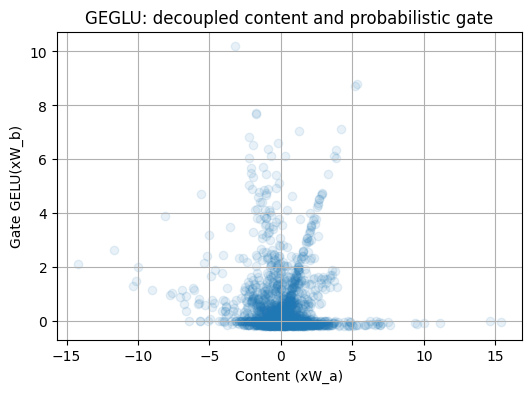

In [90]:
with torch.no_grad():
    c_flat = c.detach().flatten()
    g_flat = gate.detach().flatten()

plt.figure(figsize=(6,4))
plt.scatter(c_flat[:2000], g_flat[:2000], alpha=0.1)
plt.xlabel("Content (xW_a)")
plt.ylabel("Gate GELU(xW_b)")
plt.title("GEGLU: decoupled content and probabilistic gate")
plt.grid(True)
plt.show()



$$\text{gate} = \mathrm{GELU}(g) = g \cdot \Phi(g)$$

## Key properties
* Negative content values when gate is moderatly positive and uncertainity is not too high
* GEGLU keeps many features partially alive while uncertainity remains
GEGLU does not aggressively shut down neurons unless
* The gate is confidently negative

So,

* **GEGLU**  : uncertainity-perserving
* **SwiGLU** : uncertainity-eliminating

## Comparison SWIGLU and GEGLU
| Dimension | **SwiGLU** | **GEGLU** |
|---|---|---|
| Full form | Swish-Gated Linear Unit | Gaussian Error Gated Linear Unit |
| Formula | $(x W_a) \odot \mathrm{SiLU}(x W_b)$ | $(x W_a) \odot \mathrm{GELU}(x W_b)$ |
| Gate definition | $g \cdot \sigma(g)$ | $g \cdot \Phi(g)$ |
| Gate nature | Deterministic, logistic | Probabilistic, Gaussian |
| Content–gate relation | Parameter-decoupled, **behaviorally asymmetric** | Parameter-decoupled, **behaviorally symmetric** |
| Suppression of negative $g$ | **Strong & fast** | **Soft & gradual** |
| Gate saturation | Early for $g < 0$ | Rare (smooth tails) |
| Conditional sparsity | **High** | Moderate / soft |
| Uncertainty preservation | Low | **High** |
| Gradient flow through gate | Can vanish early | **Persistent** |
| Feature selection | **Aggressive** | Conservative / smooth |
| Training convergence | **Faster** | Slower but more stable |
| Risk of dead paths | Higher (conditional) | Lower |
| Robustness to noise | Lower | **Higher** |
| Expressivity per parameter | High | High but smoother |
| Numerical stability | Excellent | Excellent |
| Compute cost | Slightly cheaper | Slightly more expensive |
| Interpretability | Sharp on/off behavior | Expected contribution view |


## Domain specific comparison

| Dimension | **SwiGLU** | **GEGLU** |
|---|---|---|
| Full form | Swish-Gated Linear Unit | Gaussian Error Gated Linear Unit |
| Formula | $(x W_a) \odot \mathrm{SiLU}(x W_b)$ | $(x W_a) \odot \mathrm{GELU}(x W_b)$ |
| Gate definition | $g \cdot \sigma(g)$ | $g \cdot \Phi(g)$ |
| Gate nature | Deterministic, logistic | Probabilistic, Gaussian |
| Content–gate relation | Parameter-decoupled, **behaviorally asymmetric** | Parameter-decoupled, **behaviorally symmetric** |
| Suppression of negative $g$ | **Strong & fast** | **Soft & gradual** |
| Gate saturation | Early for $g < 0$ | Rare (smooth tails) |
| Conditional sparsity | **High** | Moderate / soft |
| Uncertainty preservation | Low | **High** |
| Gradient flow through gate | Can vanish early | **Persistent** |
| Feature selection | **Aggressive** | Conservative / smooth |
| Training convergence | **Faster** | Slower but more stable |
| Risk of dead paths | Higher (conditional) | Lower |
| Robustness to noise | Lower | **Higher** |
| Expressivity per parameter | High | High but smoother |
| Numerical stability | Excellent | Excellent |
| Compute cost | Slightly cheaper | Slightly more expensive |
| Interpretability | Sharp on/off behavior | Expected contribution view |


Final take away : SwiGLU maximizes decisiveness; GEGLU maximizes stability.